In [239]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import re
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [240]:
train = pd.read_csv('train.csv', parse_dates=['loss_date'])
policies = pd.read_csv('policies.csv', parse_dates=['trans_date','from_date','to_date'])
test = pd.read_csv('test.csv', parse_dates=['loss_date'])
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000


In [242]:
train.isna().sum()

claim_id              0
policy_number        86
claim_number          0
sum_insured           0
product               0
agent                 0
class_of_business     0
risk_type             0
loss_date             0
client_type           0
renewal_frequency     0
primary_cause         0
secondary_cause       0
branch                0
target                0
dtype: int64

In [243]:
train.describe(include = 'all')

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
count,9376,9290,9376,9376.00000,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376,9376.00000
unique,9376,4076,9167,NaN,37,8,37,50,1359,3,5,21,74,11,NaN
top,ID_JZ7QWRHH57RO,pol000006026,claim0001351,NaN,prod00015,ag00037,cob00034,rt00023,2019-08-20 00:00:00,ct0001,rf0002,pc0007,sc00023,br00002,NaN
freq,1,254,3,NaN,4411,3114,3608,3771,83,6096,4853,7396,2980,3900,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,8534789.61723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41464.71125
std,NaN,NaN,NaN,112556487.28996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208434.71755
min,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
25%,NaN,NaN,NaN,6500.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287.92500


In [244]:
policies.head()

,policy_number,product_code,trans_date,from_date,to_date,agent,class_of_business,client_type,renewal_frequency,branch
0,pol000006995,prod00033,2017-07-01 08:24:55.800,2017-07-01,2018-07-01,ag00005,cob00035,ct0001,rf0002,br00002
1,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03,2017-11-02,ag00226,cob00009,ct0003,rf0001,br00006
2,pol000009828,prod00005,2017-07-01 09:04:02.217,2017-07-03,2017-11-02,ag00226,cob00031,ct0003,rf0001,br00006
3,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01,2017-10-31,ag00005,cob00031,ct0003,rf0001,br00002
4,pol000007729,prod00005,2017-07-01 09:36:53.843,2017-07-01,2017-10-31,ag00005,cob00009,ct0003,rf0001,br00002


In [245]:
policies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30371 entries, 0 to 30370
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   policy_number      30371 non-null  object        
 1   product_code       30371 non-null  object        
 2   trans_date         30371 non-null  datetime64[ns]
 3   from_date          30371 non-null  datetime64[ns]
 4   to_date            30371 non-null  datetime64[ns]
 5   agent              30371 non-null  object        
 6   class_of_business  30325 non-null  object        
 7   client_type        30371 non-null  object        
 8   renewal_frequency  30371 non-null  object        
 9   branch             30371 non-null  object        
dtypes: datetime64[ns](3), object(7)
memory usage: 2.3+ MB


In [246]:
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [247]:
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch
0,ID_4RO0KZI9BBW2,pol000007115,claim0005757,300000.00000,prod00005,ag00068,cob00009,rt00032,2021-03-11,ct0003,rf0001,pc0007,sc00029,br00004
1,ID_GTE9ZUJ9GZ97,pol000006008,claim0003037,2700000.00000,prod00015,ag00064,cob00034,rt00023,2020-06-25,ct0001,rf0003,pc0007,sc00022,br00002
2,ID_RUVIYRKWZ4RG,pol000007651,claim0006507,4071352.00000,prod00012,ag00021,cob00016,rt00015,2019-03-14,ct0001,rf0001,pc0011,sc00049,br00001
3,ID_J81X8SWU6JYN,pol000010981,claim0013636,0.00000,prod00002,ag00037,cob00002,rt00002,2018-12-04,ct0001,rf0002,pc0002,sc00012,br00005
4,ID_94NM3JJAWWOQ,pol000005926,claim0001750,1607178.00000,prod00015,ag00037,cob00034,rt00023,2019-09-18,ct0001,rf0003,pc0007,sc00022,br00002


In [248]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   claim_id           4019 non-null   object        
 1   policy_number      3978 non-null   object        
 2   claim_number       4019 non-null   object        
 3   sum_insured        4019 non-null   float64       
 4   product            4019 non-null   object        
 5   agent              4019 non-null   object        
 6   class_of_business  4019 non-null   object        
 7   risk_type          4019 non-null   object        
 8   loss_date          4019 non-null   datetime64[ns]
 9   client_type        4019 non-null   object        
 10  renewal_frequency  4019 non-null   object        
 11  primary_cause      4019 non-null   object        
 12  secondary_cause    4019 non-null   object        
 13  branch             4019 non-null   object        
dtypes: datet

In [249]:
train['branch'].value_counts()

br00002    3900
br00001    3242
br00007     717
br00005     587
br00006     383
br00009     225
br00008     143
br00004     133
br00011      26
br00003      17
br00010       3
Name: branch, dtype: int64

In [250]:
test['branch'].value_counts()

br00002    1674
br00001    1385
br00007     320
br00005     233
br00006     154
br00009      99
br00008      69
br00004      66
br00011      13
br00003       5
br00010       1
Name: branch, dtype: int64

In [251]:
# Convert categorical variables to categorical objects
cat_cols = train.columns.difference(['claim_id', 'loss_date', 'sum_insured', 'target']).tolist()

# Preview categorical variables
train[cat_cols].head()

,agent,branch,claim_number,class_of_business,client_type,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause
0,ag00068,br00006,claim0011359,cob00031,ct0003,pol000009680,pc0007,prod00027,rf0001,rt00006,sc00022
1,ag00226,br00002,claim0005272,cob00010,ct0003,pol000006869,pc0007,prod00005,rf0001,rt00032,sc00023
2,ag00037,br00002,claim0004147,cob00010,ct0003,pol000006135,pc0007,prod00029,rf0001,rt00026,sc00024
3,ag00037,br00001,claim0009962,cob00009,ct0003,pol000008991,pc0007,prod00005,rf0001,rt00032,sc00021
4,ag00226,br00001,claim0007346,cob00034,ct0001,pol000007768,pc0007,prod00015,rf0001,rt00023,sc00021


In [252]:
# Fill in missing values in categorical variables with the most common
train[cat_cols] = train[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  train[col] = train[col].astype('category')

# Confirm
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   claim_id           9376 non-null   object        
 1   policy_number      9376 non-null   category      
 2   claim_number       9376 non-null   category      
 3   sum_insured        9376 non-null   float64       
 4   product            9376 non-null   category      
 5   agent              9376 non-null   category      
 6   class_of_business  9376 non-null   category      
 7   risk_type          9376 non-null   category      
 8   loss_date          9376 non-null   datetime64[ns]
 9   client_type        9376 non-null   category      
 10  renewal_frequency  9376 non-null   category      
 11  primary_cause      9376 non-null   category      
 12  secondary_cause    9376 non-null   category      
 13  branch             9376 non-null   category      
 14  target  

In [253]:
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////

In [254]:
test.isna().sum()

claim_id              0
policy_number        41
claim_number          0
sum_insured           0
product               0
agent                 0
class_of_business     0
risk_type             0
loss_date             0
client_type           0
renewal_frequency     0
primary_cause         0
secondary_cause       0
branch                0
dtype: int64

In [255]:
# Convert categorical variables to categorical objects
cat_cols2 = test.columns.difference(['claim_id','loss_date']).tolist()

# Preview categorical variables
test[cat_cols2].head()

,agent,branch,claim_number,class_of_business,client_type,policy_number,primary_cause,product,renewal_frequency,risk_type,secondary_cause,sum_insured
0,ag00068,br00004,claim0005757,cob00009,ct0003,pol000007115,pc0007,prod00005,rf0001,rt00032,sc00029,300000.00000
1,ag00064,br00002,claim0003037,cob00034,ct0001,pol000006008,pc0007,prod00015,rf0003,rt00023,sc00022,2700000.00000
2,ag00021,br00001,claim0006507,cob00016,ct0001,pol000007651,pc0011,prod00012,rf0001,rt00015,sc00049,4071352.00000
3,ag00037,br00005,claim0013636,cob00002,ct0001,pol000010981,pc0002,prod00002,rf0002,rt00002,sc00012,0.00000
4,ag00037,br00002,claim0001750,cob00034,ct0001,pol000005926,pc0007,prod00015,rf0003,rt00023,sc00022,1607178.00000


In [256]:
# Fill in missing values in categorical variables with the most common
test[cat_cols2] = test[cat_cols2].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols2:
  test[col] = test[col].astype('category')

# Confirm
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   claim_id           4019 non-null   object        
 1   policy_number      4019 non-null   category      
 2   claim_number       4019 non-null   category      
 3   sum_insured        4019 non-null   category      
 4   product            4019 non-null   category      
 5   agent              4019 non-null   category      
 6   class_of_business  4019 non-null   category      
 7   risk_type          4019 non-null   category      
 8   loss_date          4019 non-null   datetime64[ns]
 9   client_type        4019 non-null   category      
 10  renewal_frequency  4019 non-null   category      
 11  primary_cause      4019 non-null   category      
 12  secondary_cause    4019 non-null   category      
 13  branch             4019 non-null   category      
dtypes: categ

In [257]:
test['sum_insured'] = pd.to_numeric(test['sum_insured']).astype(float)

In [258]:
test.isna().sum()

claim_id             0
policy_number        0
claim_number         0
sum_insured          0
product              0
agent                0
class_of_business    0
risk_type            0
loss_date            0
client_type          0
renewal_frequency    0
primary_cause        0
secondary_cause      0
branch               0
dtype: int64

In [259]:
# //////////////////////////////////////////////////////////////////////////////////////////////////////////

In [260]:
policies.isna().sum()

policy_number         0
product_code          0
trans_date            0
from_date             0
to_date               0
agent                 0
class_of_business    46
client_type           0
renewal_frequency     0
branch                0
dtype: int64

In [261]:
# Convert categorical variables to categorical objects
cat_cols3 = policies.columns.difference(['trans_date','from_date','to_date']).tolist()

# Preview categorical variables
policies[cat_cols3].head()

,agent,branch,class_of_business,client_type,policy_number,product_code,renewal_frequency
0,ag00005,br00002,cob00035,ct0001,pol000006995,prod00033,rf0002
1,ag00226,br00006,cob00009,ct0003,pol000009828,prod00005,rf0001
2,ag00226,br00006,cob00031,ct0003,pol000009828,prod00005,rf0001
3,ag00005,br00002,cob00031,ct0003,pol000007729,prod00005,rf0001
4,ag00005,br00002,cob00009,ct0003,pol000007729,prod00005,rf0001


In [262]:
# Fill in missing values in categorical variables with the most common
policies[cat_cols3] = policies[cat_cols3].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols3:
  policies[col] = policies[col].astype('category')

# Confirm
policies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30371 entries, 0 to 30370
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   policy_number      30371 non-null  category      
 1   product_code       30371 non-null  category      
 2   trans_date         30371 non-null  datetime64[ns]
 3   from_date          30371 non-null  datetime64[ns]
 4   to_date            30371 non-null  datetime64[ns]
 5   agent              30371 non-null  category      
 6   class_of_business  30371 non-null  category      
 7   client_type        30371 non-null  category      
 8   renewal_frequency  30371 non-null  category      
 9   branch             30371 non-null  category      
dtypes: category(7), datetime64[ns](3)
memory usage: 1.1 MB


In [263]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any(), policies.isnull().sum().any()

(False, False, False)

In [264]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any(), policies.duplicated().any()

(False, False, False)

In [265]:
# /////////////////////////////////////////////////////////////////////////////////////////////////////////

In [266]:
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000


In [267]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   claim_id           9376 non-null   object        
 1   policy_number      9376 non-null   category      
 2   claim_number       9376 non-null   category      
 3   sum_insured        9376 non-null   float64       
 4   product            9376 non-null   category      
 5   agent              9376 non-null   category      
 6   class_of_business  9376 non-null   category      
 7   risk_type          9376 non-null   category      
 8   loss_date          9376 non-null   datetime64[ns]
 9   client_type        9376 non-null   category      
 10  renewal_frequency  9376 non-null   category      
 11  primary_cause      9376 non-null   category      
 12  secondary_cause    9376 non-null   category      
 13  branch             9376 non-null   category      
 14  target  

In [268]:
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,300000.00000,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,82150.00000
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,16000.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,3780.24000
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,3000.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,2196.50000
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,6000.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,105.67000
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,26850.00000,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,1605.64000


In [269]:
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch
0,ID_4RO0KZI9BBW2,pol000007115,claim0005757,300000.00000,prod00005,ag00068,cob00009,rt00032,2021-03-11,ct0003,rf0001,pc0007,sc00029,br00004
1,ID_GTE9ZUJ9GZ97,pol000006008,claim0003037,2700000.00000,prod00015,ag00064,cob00034,rt00023,2020-06-25,ct0001,rf0003,pc0007,sc00022,br00002
2,ID_RUVIYRKWZ4RG,pol000007651,claim0006507,4071352.00000,prod00012,ag00021,cob00016,rt00015,2019-03-14,ct0001,rf0001,pc0011,sc00049,br00001
3,ID_J81X8SWU6JYN,pol000010981,claim0013636,0.00000,prod00002,ag00037,cob00002,rt00002,2018-12-04,ct0001,rf0002,pc0002,sc00012,br00005
4,ID_94NM3JJAWWOQ,pol000005926,claim0001750,1607178.00000,prod00015,ag00037,cob00034,rt00023,2019-09-18,ct0001,rf0003,pc0007,sc00022,br00002


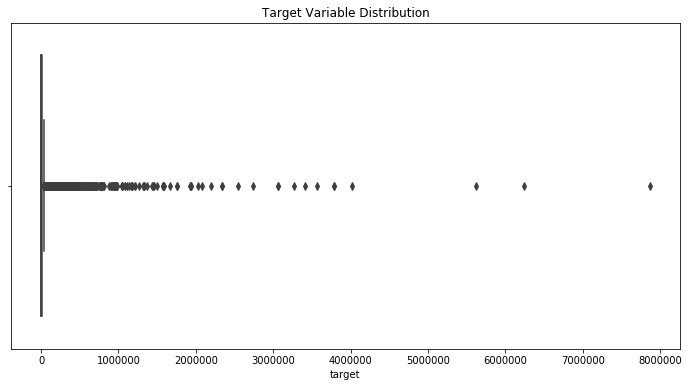

In [270]:
# OUTLIERS

# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(train.target)
plt.title('Target Variable Distribution');

In [271]:
from sklearn.preprocessing import MinMaxScaler

In [272]:
scaler = MinMaxScaler()
train[['sum_insured','target']] = scaler.fit_transform(train[['sum_insured','target']])
test[['sum_insured']] = scaler.fit_transform(test[['sum_insured']])

In [273]:
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,renewal_frequency,primary_cause,secondary_cause,branch,target
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,0.00006,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,rf0001,pc0007,sc00022,br00006,0.01044
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,0.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,rf0001,pc0007,sc00023,br00002,0.00048
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,0.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,rf0001,pc0007,sc00024,br00002,0.00028
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,0.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,rf0001,pc0007,sc00021,br00001,0.00001
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,0.00001,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,rf0001,pc0007,sc00021,br00001,0.00020


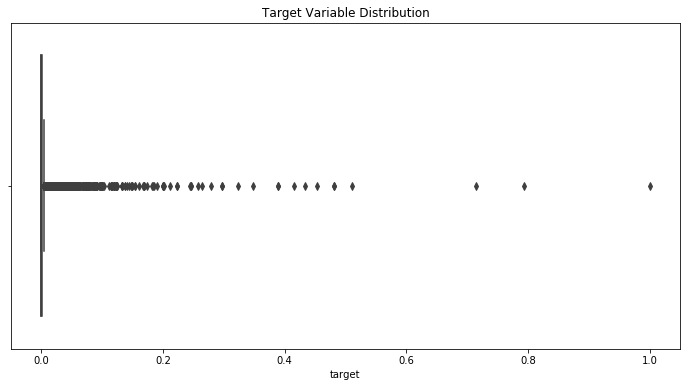

In [274]:
# OUTLIERS

# A box plot showing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(train.target)
plt.title('Target Variable Distribution');

In [275]:
# Convert datetime variables to datetime objects
train.loss_date = pd.to_datetime(train.loss_date, errors='coerce')

# Confirm that the dates have been converted successfully 
train.loss_date.describe()

count                    9376
unique                   1359
top       2019-08-20 00:00:00
freq                       83
first     2018-01-01 00:00:00
last      2021-10-22 00:00:00
Name: loss_date, dtype: object

In [276]:
from fast_ml.feature_engineering import FeatureEngineering_DateTime

dt_fe = FeatureEngineering_DateTime()

dt_fe.fit(train, datetime_variables=['loss_date'], prefix = 'loss_date:')
dt_fe.fit(test, datetime_variables=['loss_date'], prefix = 'loss_date:')

train = dt_fe.transform(train)
test = dt_fe.transform(test)
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,loss_date,client_type,...,loss_date:is_quarter_end,loss_date:is_quarter_start,loss_date:is_year_end,loss_date:is_year_start,loss_date:time,loss_date:hour,loss_date:minute,loss_date:second,loss_date:is_weekend,loss_date:day_part
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,0.00006,prod00027,ag00068,cob00031,rt00006,2021-05-13,ct0003,...,False,False,False,False,00:00:00,0,0,0,0,None
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,0.00000,prod00005,ag00226,cob00010,rt00032,2018-05-13,ct0003,...,False,False,False,False,00:00:00,0,0,0,1,None
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,0.00000,prod00029,ag00037,cob00010,rt00026,2018-08-18,ct0003,...,False,False,False,False,00:00:00,0,0,0,1,None
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,0.00000,prod00005,ag00037,cob00009,rt00032,2018-12-20,ct0003,...,False,False,False,False,00:00:00,0,0,0,0,None
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,0.00001,prod00015,ag00226,cob00034,rt00023,2018-11-07,ct0001,...,False,False,False,False,00:00:00,0,0,0,0,None


In [277]:
train.drop(['loss_date'],axis=1,inplace=True) 
test.drop(['loss_date'],axis=1,inplace=True)

In [278]:
train.drop(['loss_date:time'],axis=1,inplace=True) 
test.drop(['loss_date:time'],axis=1,inplace=True) 

In [279]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   claim_id                    9376 non-null   object  
 1   policy_number               9376 non-null   category
 2   claim_number                9376 non-null   category
 3   sum_insured                 9376 non-null   float64 
 4   product                     9376 non-null   category
 5   agent                       9376 non-null   category
 6   class_of_business           9376 non-null   category
 7   risk_type                   9376 non-null   category
 8   client_type                 9376 non-null   category
 9   renewal_frequency           9376 non-null   category
 10  primary_cause               9376 non-null   category
 11  secondary_cause             9376 non-null   category
 12  branch                      9376 non-null   category
 13  target            

In [280]:
# !pip install fast_ml

In [281]:
train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,client_type,renewal_frequency,...,loss_date:is_month_start,loss_date:is_quarter_end,loss_date:is_quarter_start,loss_date:is_year_end,loss_date:is_year_start,loss_date:hour,loss_date:minute,loss_date:second,loss_date:is_weekend,loss_date:day_part
0,ID_JZ7QWRHH57RO,pol000009680,claim0011359,0.00006,prod00027,ag00068,cob00031,rt00006,ct0003,rf0001,...,False,False,False,False,False,0,0,0,0,None
1,ID_KQ5TJMVLJ4EP,pol000006869,claim0005272,0.00000,prod00005,ag00226,cob00010,rt00032,ct0003,rf0001,...,False,False,False,False,False,0,0,0,1,None
2,ID_NYHI7WJGGIAE,pol000006135,claim0004147,0.00000,prod00029,ag00037,cob00010,rt00026,ct0003,rf0001,...,False,False,False,False,False,0,0,0,1,None
3,ID_ROMMDCXYUXN5,pol000008991,claim0009962,0.00000,prod00005,ag00037,cob00009,rt00032,ct0003,rf0001,...,False,False,False,False,False,0,0,0,0,None
4,ID_2OTD9NX8L73D,pol000007768,claim0007346,0.00001,prod00015,ag00226,cob00034,rt00023,ct0001,rf0001,...,False,False,False,False,False,0,0,0,0,None


In [282]:
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,client_type,renewal_frequency,...,loss_date:is_month_start,loss_date:is_quarter_end,loss_date:is_quarter_start,loss_date:is_year_end,loss_date:is_year_start,loss_date:hour,loss_date:minute,loss_date:second,loss_date:is_weekend,loss_date:day_part
0,ID_4RO0KZI9BBW2,pol000007115,claim0005757,0.00002,prod00005,ag00068,cob00009,rt00032,ct0003,rf0001,...,False,False,False,False,False,0,0,0,0,None
1,ID_GTE9ZUJ9GZ97,pol000006008,claim0003037,0.00019,prod00015,ag00064,cob00034,rt00023,ct0001,rf0003,...,False,False,False,False,False,0,0,0,0,None
2,ID_RUVIYRKWZ4RG,pol000007651,claim0006507,0.00029,prod00012,ag00021,cob00016,rt00015,ct0001,rf0001,...,False,False,False,False,False,0,0,0,0,None
3,ID_J81X8SWU6JYN,pol000010981,claim0013636,0.00000,prod00002,ag00037,cob00002,rt00002,ct0001,rf0002,...,False,False,False,False,False,0,0,0,0,None
4,ID_94NM3JJAWWOQ,pol000005926,claim0001750,0.00011,prod00015,ag00037,cob00034,rt00023,ct0001,rf0003,...,False,False,False,False,False,0,0,0,0,None


In [283]:
train.drop(['loss_date:day_part'],axis=1,inplace=True) 
test.drop(['loss_date:day_part'],axis=1,inplace=True) 

In [284]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4019 entries, 0 to 4018
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   claim_id                    4019 non-null   object  
 1   policy_number               4019 non-null   category
 2   claim_number                4019 non-null   category
 3   sum_insured                 4019 non-null   float64 
 4   product                     4019 non-null   category
 5   agent                       4019 non-null   category
 6   class_of_business           4019 non-null   category
 7   risk_type                   4019 non-null   category
 8   client_type                 4019 non-null   category
 9   renewal_frequency           4019 non-null   category
 10  primary_cause               4019 non-null   category
 11  secondary_cause             4019 non-null   category
 12  branch                      4019 non-null   category
 13  loss_date:year    

In [285]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   claim_id                    9376 non-null   object  
 1   policy_number               9376 non-null   category
 2   claim_number                9376 non-null   category
 3   sum_insured                 9376 non-null   float64 
 4   product                     9376 non-null   category
 5   agent                       9376 non-null   category
 6   class_of_business           9376 non-null   category
 7   risk_type                   9376 non-null   category
 8   client_type                 9376 non-null   category
 9   renewal_frequency           9376 non-null   category
 10  primary_cause               9376 non-null   category
 11  secondary_cause             9376 non-null   category
 12  branch                      9376 non-null   category
 13  target            

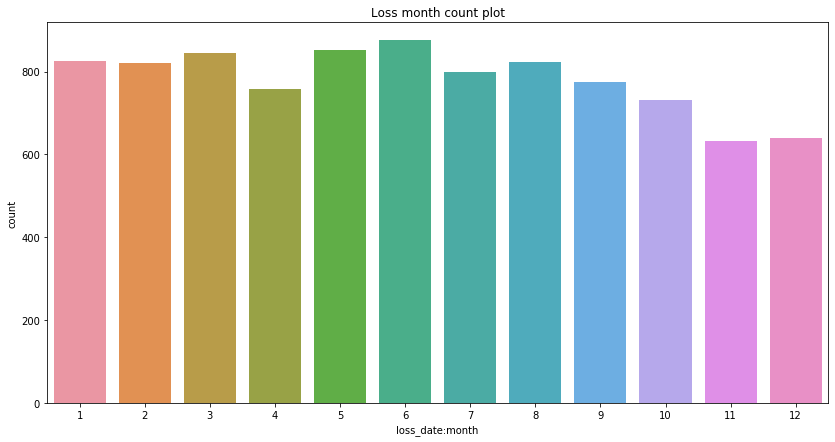

In [286]:
# Loss month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'loss_date:month', data = train)
plt.title('Loss month count plot')
plt.show()

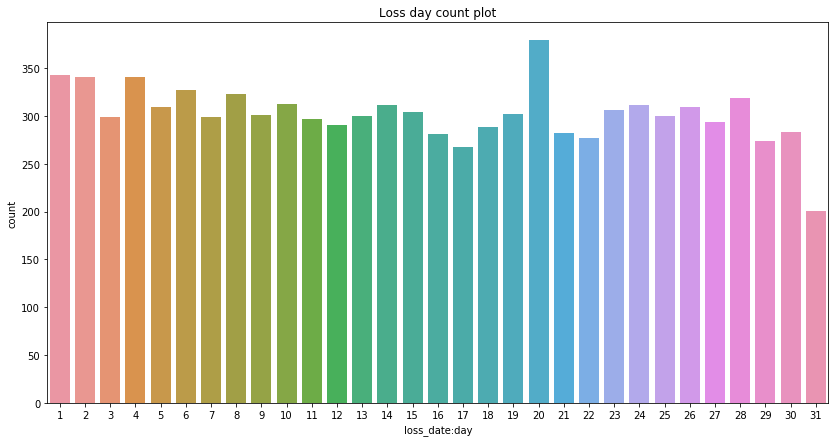

In [287]:
# Loss day countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'loss_date:day', data = train)
plt.title('Loss day count plot')
plt.show()

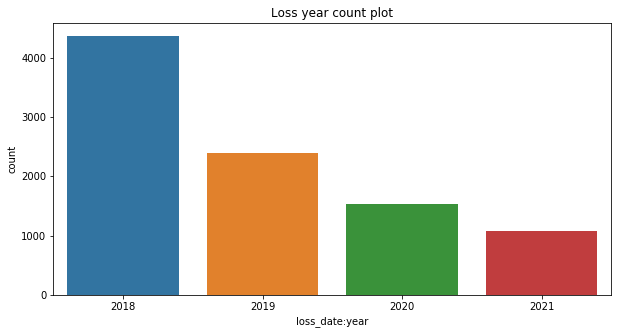

In [288]:
# Loss year countplot
plt.figure(figsize = (10, 5))
sns.countplot(x = 'loss_date:year', data = train)
plt.title('Loss year count plot')
plt.show()

In [289]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////////

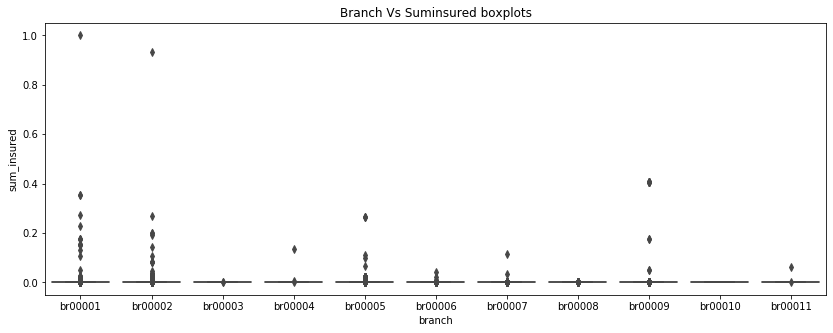

In [290]:
plt.figure(figsize = (14, 5))
sns.boxplot(x = 'branch', y = 'sum_insured', data = train)
plt.title('Branch Vs Suminsured boxplots')
plt.show()

In [291]:
train['branch'].value_counts()

br00002    3900
br00001    3242
br00007     717
br00005     587
br00006     383
br00009     225
br00008     143
br00004     133
br00011      26
br00003      17
br00010       3
Name: branch, dtype: int64

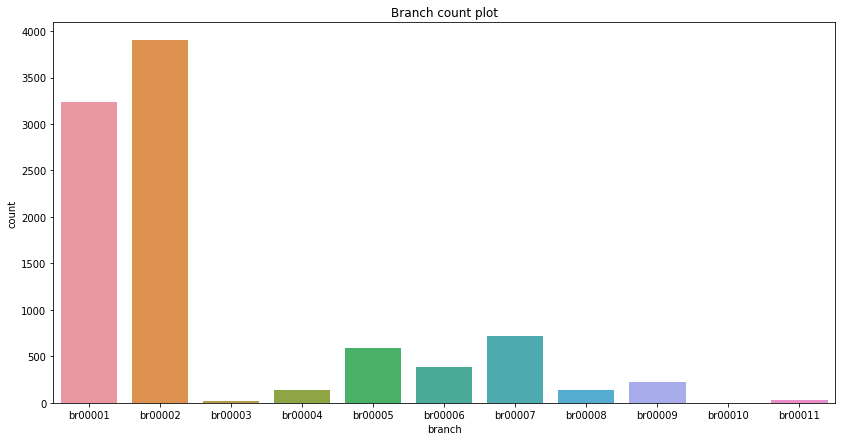

In [292]:
# Branch countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'branch', data = train)
plt.title('Branch count plot')
plt.show()

In [293]:
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////

In [294]:
# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  train[col] = le.fit_transform(train[col])
  test[col] = le.fit_transform(test[col])  

train.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,client_type,renewal_frequency,...,loss_date:is_month_end,loss_date:is_month_start,loss_date:is_quarter_end,loss_date:is_quarter_start,loss_date:is_year_end,loss_date:is_year_start,loss_date:hour,loss_date:minute,loss_date:second,loss_date:is_weekend
0,ID_JZ7QWRHH57RO,3070,7439,0.00006,26,4,30,5,2,0,...,False,False,False,False,False,False,0,0,0,0
1,ID_KQ5TJMVLJ4EP,1126,3469,0.00000,4,7,9,31,2,0,...,False,False,False,False,False,False,0,0,0,1
2,ID_NYHI7WJGGIAE,630,2799,0.00000,28,1,9,25,2,0,...,False,False,False,False,False,False,0,0,0,1
3,ID_ROMMDCXYUXN5,2546,6448,0.00000,4,1,8,31,2,0,...,False,False,False,False,False,False,0,0,0,0
4,ID_2OTD9NX8L73D,1767,4832,0.00001,14,7,32,22,0,0,...,False,False,False,False,False,False,0,0,0,0


In [295]:
test.head()

,claim_id,policy_number,claim_number,sum_insured,product,agent,class_of_business,risk_type,client_type,renewal_frequency,...,loss_date:is_month_end,loss_date:is_month_start,loss_date:is_quarter_end,loss_date:is_quarter_start,loss_date:is_year_end,loss_date:is_year_start,loss_date:hour,loss_date:minute,loss_date:second,loss_date:is_weekend
0,ID_4RO0KZI9BBW2,739,1667,0.00002,4,4,8,29,2,0,...,False,False,False,False,False,False,0,0,0,0
1,ID_GTE9ZUJ9GZ97,312,883,0.00019,12,3,28,20,0,2,...,False,False,False,False,False,False,0,0,0,0
2,ID_RUVIYRKWZ4RG,917,1895,0.00029,10,0,14,14,0,0,...,False,False,False,False,False,False,0,0,0,0
3,ID_J81X8SWU6JYN,2081,3852,0.00000,1,1,1,1,0,1,...,False,False,False,False,False,False,0,0,0,0
4,ID_94NM3JJAWWOQ,257,507,0.00011,12,1,28,20,0,2,...,False,False,False,False,False,False,0,0,0,0


In [296]:
# FEATURE ENGINEERING
for dataset in (train, test):
    dataset['policy_and_claim'] = dataset['policy_number'] + dataset['claim_number']

In [297]:
for dataset in (train, test):
    dataset['risk_and_client'] = dataset['risk_type'] + dataset['client_type']

In [298]:
for dataset in (train, test):
    dataset['primary_and_secondary'] = dataset['primary_cause'] + dataset['secondary_cause']

In [299]:
for dataset in (train, test):
    dataset['branch_and_sum_insured'] = dataset['branch'] + dataset['sum_insured']

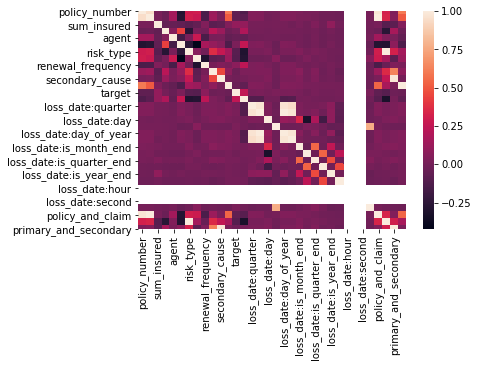

In [300]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix);

In [301]:
train.corr()['target'].sort_values(ascending=False)

target                        1.00000
loss_date:year                0.25627
sum_insured                   0.10260
renewal_frequency             0.07978
loss_date:weekofyear          0.02926
class_of_business             0.02771
loss_date:day_of_week         0.02470
loss_date:day_of_year         0.02334
loss_date:month               0.02215
loss_date:is_weekend          0.01902
loss_date:quarter             0.01769
loss_date:is_quarter_end      0.01747
loss_date:is_month_end        0.01732
loss_date:day                 0.00963
loss_date:is_year_start       0.00470
product                       0.00426
loss_date:is_quarter_start   -0.00081
loss_date:is_year_end        -0.00086
loss_date:is_month_start     -0.00561
secondary_cause              -0.01364
primary_and_secondary        -0.01723
primary_cause                -0.02290
branch_and_sum_insured       -0.02649
branch                       -0.02749
agent                        -0.04057
policy_number                -0.06457
policy_and_c

In [302]:
train.drop(['loss_date:second','loss_date:minute','loss_date:hour','loss_date:is_month_start','loss_date:is_year_end','loss_date:is_quarter_start','product','loss_date:is_year_start','loss_date:day'],axis=1,inplace=True)
test.drop(['loss_date:second','loss_date:minute','loss_date:hour','loss_date:is_month_start','loss_date:is_year_end','loss_date:is_quarter_start','product','loss_date:is_year_start','loss_date:day'],axis=1,inplace=True)

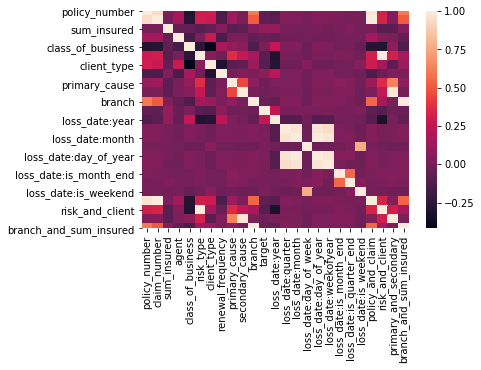

In [303]:
corr_matrix = train.corr()
sns.heatmap(corr_matrix);

In [304]:
train.corr()['target'].sort_values(ascending=False)

target                      1.00000
loss_date:year              0.25627
sum_insured                 0.10260
renewal_frequency           0.07978
loss_date:weekofyear        0.02926
class_of_business           0.02771
loss_date:day_of_week       0.02470
loss_date:day_of_year       0.02334
loss_date:month             0.02215
loss_date:is_weekend        0.01902
loss_date:quarter           0.01769
loss_date:is_quarter_end    0.01747
loss_date:is_month_end      0.01732
secondary_cause            -0.01364
primary_and_secondary      -0.01723
primary_cause              -0.02290
branch_and_sum_insured     -0.02649
branch                     -0.02749
agent                      -0.04057
policy_number              -0.06457
policy_and_claim           -0.06889
claim_number               -0.06964
risk_type                  -0.09025
client_type                -0.09840
risk_and_client            -0.09866
Name: target, dtype: float64

In [305]:
# //////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [306]:
# MODELLING

# Select main columns to be used in training
main_cols = train.columns.difference(['claim_id', 'target']).tolist()
X = train[main_cols]
y = train.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the MAE score of the model
print(f'LinearRegression MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

LinearRegression MAE score on the X_test is: 0.007735976942492261


In [307]:
# //////////////////////////////////////////////////////////////////////////////////////////////////////////

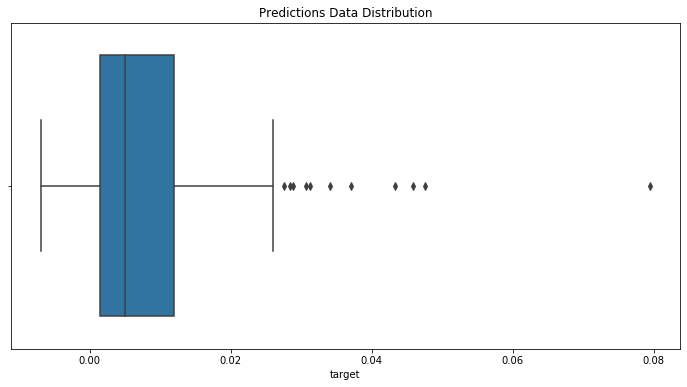

In [308]:
# Make prediction on the test set
test_df = test[main_cols]
predictions = model.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.target)
plt.title('Predictions Data Distribution');

In [309]:
# Preview the sub_file
sub_file.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,0.01995
1,ID_GTE9ZUJ9GZ97,0.01378
2,ID_RUVIYRKWZ4RG,0.00913
3,ID_J81X8SWU6JYN,0.00498
4,ID_94NM3JJAWWOQ,0.00878


In [310]:
# Write to csv file to submit to Zindi
sub_file.to_csv("16th submission.csv", index = False)

In [311]:
# /////////////////////////////////////////////////////////////////////////////////////////////////////

In [312]:
from catboost import CatBoostRegressor
for max_depth in [3, 5, 8, 10, 14, 18]:
    ml = CatBoostRegressor()
    # Again, you van use a better method to evaluate the model here...
    ml.fit(X_train, y_train)

Learning rate set to 0.055117
0:	learn: 0.0242333	total: 5.7ms	remaining: 5.69s
1:	learn: 0.0240566	total: 10.2ms	remaining: 5.07s
2:	learn: 0.0239378	total: 14.9ms	remaining: 4.94s
3:	learn: 0.0237720	total: 19ms	remaining: 4.73s
4:	learn: 0.0235832	total: 22.9ms	remaining: 4.56s
5:	learn: 0.0234587	total: 27ms	remaining: 4.47s
6:	learn: 0.0232674	total: 30.5ms	remaining: 4.33s
7:	learn: 0.0231522	total: 35.3ms	remaining: 4.38s
8:	learn: 0.0230259	total: 39.2ms	remaining: 4.32s
9:	learn: 0.0229250	total: 44ms	remaining: 4.36s
10:	learn: 0.0227644	total: 48.1ms	remaining: 4.32s
11:	learn: 0.0226069	total: 58.3ms	remaining: 4.8s
12:	learn: 0.0225451	total: 67ms	remaining: 5.09s
13:	learn: 0.0224238	total: 75.1ms	remaining: 5.29s
14:	learn: 0.0223487	total: 85ms	remaining: 5.58s
15:	learn: 0.0222810	total: 96ms	remaining: 5.9s
16:	learn: 0.0221915	total: 107ms	remaining: 6.21s
17:	learn: 0.0221317	total: 141ms	remaining: 7.69s
18:	learn: 0.0220369	total: 151ms	remaining: 7.82s
19:	learn:

181:	learn: 0.0163717	total: 1.24s	remaining: 5.59s
182:	learn: 0.0163590	total: 1.25s	remaining: 5.59s
183:	learn: 0.0163421	total: 1.26s	remaining: 5.59s
184:	learn: 0.0163299	total: 1.27s	remaining: 5.59s
185:	learn: 0.0163244	total: 1.28s	remaining: 5.59s
186:	learn: 0.0163114	total: 1.29s	remaining: 5.61s
187:	learn: 0.0162994	total: 1.3s	remaining: 5.63s
188:	learn: 0.0162703	total: 1.31s	remaining: 5.62s
189:	learn: 0.0162550	total: 1.32s	remaining: 5.64s
190:	learn: 0.0162529	total: 1.34s	remaining: 5.67s
191:	learn: 0.0162409	total: 1.34s	remaining: 5.64s
192:	learn: 0.0162084	total: 1.35s	remaining: 5.63s
193:	learn: 0.0161973	total: 1.35s	remaining: 5.61s
194:	learn: 0.0161730	total: 1.35s	remaining: 5.59s
195:	learn: 0.0161407	total: 1.36s	remaining: 5.57s
196:	learn: 0.0161389	total: 1.36s	remaining: 5.55s
197:	learn: 0.0161270	total: 1.37s	remaining: 5.54s
198:	learn: 0.0161167	total: 1.37s	remaining: 5.52s
199:	learn: 0.0161067	total: 1.38s	remaining: 5.5s
200:	learn: 0.

378:	learn: 0.0129552	total: 2.45s	remaining: 4.01s
379:	learn: 0.0129316	total: 2.45s	remaining: 4s
380:	learn: 0.0129147	total: 2.45s	remaining: 3.99s
381:	learn: 0.0129107	total: 2.46s	remaining: 3.98s
382:	learn: 0.0129065	total: 2.46s	remaining: 3.97s
383:	learn: 0.0129035	total: 2.47s	remaining: 3.96s
384:	learn: 0.0129006	total: 2.47s	remaining: 3.95s
385:	learn: 0.0128890	total: 2.48s	remaining: 3.94s
386:	learn: 0.0128717	total: 2.48s	remaining: 3.92s
387:	learn: 0.0128675	total: 2.48s	remaining: 3.91s
388:	learn: 0.0128561	total: 2.49s	remaining: 3.91s
389:	learn: 0.0128523	total: 2.49s	remaining: 3.9s
390:	learn: 0.0128487	total: 2.5s	remaining: 3.89s
391:	learn: 0.0128419	total: 2.5s	remaining: 3.89s
392:	learn: 0.0128264	total: 2.51s	remaining: 3.88s
393:	learn: 0.0128109	total: 2.52s	remaining: 3.88s
394:	learn: 0.0127890	total: 2.52s	remaining: 3.87s
395:	learn: 0.0127856	total: 2.53s	remaining: 3.86s
396:	learn: 0.0127791	total: 2.54s	remaining: 3.86s
397:	learn: 0.0127

548:	learn: 0.0114002	total: 3.46s	remaining: 2.85s
549:	learn: 0.0113963	total: 3.47s	remaining: 2.84s
550:	learn: 0.0113948	total: 3.49s	remaining: 2.84s
551:	learn: 0.0113863	total: 3.5s	remaining: 2.84s
552:	learn: 0.0113850	total: 3.51s	remaining: 2.83s
553:	learn: 0.0113750	total: 3.52s	remaining: 2.83s
554:	learn: 0.0113642	total: 3.52s	remaining: 2.83s
555:	learn: 0.0113605	total: 3.53s	remaining: 2.82s
556:	learn: 0.0113595	total: 3.54s	remaining: 2.82s
557:	learn: 0.0113490	total: 3.55s	remaining: 2.81s
558:	learn: 0.0113449	total: 3.56s	remaining: 2.81s
559:	learn: 0.0113342	total: 3.57s	remaining: 2.81s
560:	learn: 0.0113336	total: 3.58s	remaining: 2.8s
561:	learn: 0.0113284	total: 3.59s	remaining: 2.8s
562:	learn: 0.0113188	total: 3.6s	remaining: 2.79s
563:	learn: 0.0113140	total: 3.61s	remaining: 2.79s
564:	learn: 0.0113125	total: 3.62s	remaining: 2.79s
565:	learn: 0.0113031	total: 3.63s	remaining: 2.79s
566:	learn: 0.0112974	total: 3.66s	remaining: 2.79s
567:	learn: 0.01

716:	learn: 0.0102271	total: 4.52s	remaining: 1.78s
717:	learn: 0.0102226	total: 4.53s	remaining: 1.78s
718:	learn: 0.0102126	total: 4.53s	remaining: 1.77s
719:	learn: 0.0102083	total: 4.54s	remaining: 1.76s
720:	learn: 0.0102042	total: 4.55s	remaining: 1.76s
721:	learn: 0.0102035	total: 4.56s	remaining: 1.75s
722:	learn: 0.0101968	total: 4.57s	remaining: 1.75s
723:	learn: 0.0101892	total: 4.58s	remaining: 1.75s
724:	learn: 0.0101835	total: 4.59s	remaining: 1.74s
725:	learn: 0.0101828	total: 4.6s	remaining: 1.74s
726:	learn: 0.0101734	total: 4.61s	remaining: 1.73s
727:	learn: 0.0101697	total: 4.62s	remaining: 1.73s
728:	learn: 0.0101660	total: 4.62s	remaining: 1.72s
729:	learn: 0.0101589	total: 4.63s	remaining: 1.71s
730:	learn: 0.0101553	total: 4.63s	remaining: 1.71s
731:	learn: 0.0101510	total: 4.64s	remaining: 1.7s
732:	learn: 0.0101476	total: 4.64s	remaining: 1.69s
733:	learn: 0.0101425	total: 4.65s	remaining: 1.68s
734:	learn: 0.0101365	total: 4.67s	remaining: 1.68s
735:	learn: 0.

879:	learn: 0.0093713	total: 5.54s	remaining: 756ms
880:	learn: 0.0093686	total: 5.54s	remaining: 749ms
881:	learn: 0.0093661	total: 5.55s	remaining: 742ms
882:	learn: 0.0093636	total: 5.55s	remaining: 736ms
883:	learn: 0.0093591	total: 5.56s	remaining: 729ms
884:	learn: 0.0093503	total: 5.56s	remaining: 723ms
885:	learn: 0.0093480	total: 5.57s	remaining: 716ms
886:	learn: 0.0093420	total: 5.57s	remaining: 710ms
887:	learn: 0.0093390	total: 5.57s	remaining: 703ms
888:	learn: 0.0093377	total: 5.58s	remaining: 697ms
889:	learn: 0.0093370	total: 5.58s	remaining: 690ms
890:	learn: 0.0093312	total: 5.59s	remaining: 683ms
891:	learn: 0.0093300	total: 5.59s	remaining: 677ms
892:	learn: 0.0093271	total: 5.59s	remaining: 671ms
893:	learn: 0.0093177	total: 5.6s	remaining: 664ms
894:	learn: 0.0093115	total: 5.6s	remaining: 658ms
895:	learn: 0.0093089	total: 5.61s	remaining: 651ms
896:	learn: 0.0093079	total: 5.61s	remaining: 645ms
897:	learn: 0.0092985	total: 5.62s	remaining: 638ms
898:	learn: 0.

51:	learn: 0.0200415	total: 175ms	remaining: 3.19s
52:	learn: 0.0200291	total: 180ms	remaining: 3.21s
53:	learn: 0.0199679	total: 189ms	remaining: 3.31s
54:	learn: 0.0199582	total: 196ms	remaining: 3.38s
55:	learn: 0.0199227	total: 208ms	remaining: 3.51s
56:	learn: 0.0198931	total: 212ms	remaining: 3.51s
57:	learn: 0.0198823	total: 218ms	remaining: 3.53s
58:	learn: 0.0198433	total: 222ms	remaining: 3.54s
59:	learn: 0.0197935	total: 226ms	remaining: 3.54s
60:	learn: 0.0197671	total: 231ms	remaining: 3.56s
61:	learn: 0.0197297	total: 236ms	remaining: 3.57s
62:	learn: 0.0197150	total: 240ms	remaining: 3.57s
63:	learn: 0.0196788	total: 244ms	remaining: 3.57s
64:	learn: 0.0196481	total: 250ms	remaining: 3.59s
65:	learn: 0.0196349	total: 255ms	remaining: 3.61s
66:	learn: 0.0195729	total: 265ms	remaining: 3.69s
67:	learn: 0.0195494	total: 275ms	remaining: 3.77s
68:	learn: 0.0194924	total: 286ms	remaining: 3.86s
69:	learn: 0.0194827	total: 298ms	remaining: 3.96s
70:	learn: 0.0194493	total: 303

224:	learn: 0.0157571	total: 1.21s	remaining: 4.17s
225:	learn: 0.0157506	total: 1.22s	remaining: 4.17s
226:	learn: 0.0157435	total: 1.22s	remaining: 4.16s
227:	learn: 0.0157259	total: 1.23s	remaining: 4.16s
228:	learn: 0.0157044	total: 1.23s	remaining: 4.15s
229:	learn: 0.0156982	total: 1.24s	remaining: 4.14s
230:	learn: 0.0156922	total: 1.25s	remaining: 4.16s
231:	learn: 0.0156614	total: 1.26s	remaining: 4.17s
232:	learn: 0.0156555	total: 1.27s	remaining: 4.17s
233:	learn: 0.0156542	total: 1.28s	remaining: 4.18s
234:	learn: 0.0156485	total: 1.28s	remaining: 4.17s
235:	learn: 0.0156026	total: 1.29s	remaining: 4.19s
236:	learn: 0.0155971	total: 1.3s	remaining: 4.18s
237:	learn: 0.0155917	total: 1.31s	remaining: 4.19s
238:	learn: 0.0155896	total: 1.31s	remaining: 4.18s
239:	learn: 0.0155843	total: 1.33s	remaining: 4.2s
240:	learn: 0.0155538	total: 1.34s	remaining: 4.22s
241:	learn: 0.0155487	total: 1.36s	remaining: 4.25s
242:	learn: 0.0155436	total: 1.37s	remaining: 4.26s
243:	learn: 0.

399:	learn: 0.0127374	total: 2.42s	remaining: 3.63s
400:	learn: 0.0127261	total: 2.43s	remaining: 3.63s
401:	learn: 0.0127201	total: 2.44s	remaining: 3.62s
402:	learn: 0.0127049	total: 2.44s	remaining: 3.62s
403:	learn: 0.0126964	total: 2.45s	remaining: 3.61s
404:	learn: 0.0126867	total: 2.45s	remaining: 3.6s
405:	learn: 0.0126716	total: 2.46s	remaining: 3.6s
406:	learn: 0.0126629	total: 2.46s	remaining: 3.59s
407:	learn: 0.0126448	total: 2.47s	remaining: 3.58s
408:	learn: 0.0126313	total: 2.47s	remaining: 3.58s
409:	learn: 0.0126184	total: 2.48s	remaining: 3.57s
410:	learn: 0.0126038	total: 2.48s	remaining: 3.56s
411:	learn: 0.0125896	total: 2.49s	remaining: 3.55s
412:	learn: 0.0125789	total: 2.49s	remaining: 3.54s
413:	learn: 0.0125692	total: 2.5s	remaining: 3.54s
414:	learn: 0.0125660	total: 2.5s	remaining: 3.53s
415:	learn: 0.0125522	total: 2.51s	remaining: 3.52s
416:	learn: 0.0125421	total: 2.51s	remaining: 3.51s
417:	learn: 0.0125414	total: 2.51s	remaining: 3.5s
418:	learn: 0.012

574:	learn: 0.0112355	total: 3.45s	remaining: 2.55s
575:	learn: 0.0112237	total: 3.45s	remaining: 2.54s
576:	learn: 0.0112223	total: 3.45s	remaining: 2.53s
577:	learn: 0.0112210	total: 3.46s	remaining: 2.52s
578:	learn: 0.0112131	total: 3.46s	remaining: 2.52s
579:	learn: 0.0112084	total: 3.46s	remaining: 2.51s
580:	learn: 0.0112009	total: 3.47s	remaining: 2.5s
581:	learn: 0.0111878	total: 3.47s	remaining: 2.49s
582:	learn: 0.0111845	total: 3.48s	remaining: 2.49s
583:	learn: 0.0111831	total: 3.48s	remaining: 2.48s
584:	learn: 0.0111592	total: 3.48s	remaining: 2.47s
585:	learn: 0.0111492	total: 3.48s	remaining: 2.46s
586:	learn: 0.0111457	total: 3.49s	remaining: 2.45s
587:	learn: 0.0111356	total: 3.49s	remaining: 2.45s
588:	learn: 0.0111318	total: 3.5s	remaining: 2.44s
589:	learn: 0.0111288	total: 3.5s	remaining: 2.43s
590:	learn: 0.0111197	total: 3.51s	remaining: 2.43s
591:	learn: 0.0111099	total: 3.51s	remaining: 2.42s
592:	learn: 0.0111014	total: 3.51s	remaining: 2.41s
593:	learn: 0.0

751:	learn: 0.0100344	total: 4.5s	remaining: 1.48s
752:	learn: 0.0100312	total: 4.5s	remaining: 1.48s
753:	learn: 0.0100257	total: 4.51s	remaining: 1.47s
754:	learn: 0.0100154	total: 4.52s	remaining: 1.47s
755:	learn: 0.0100114	total: 4.53s	remaining: 1.46s
756:	learn: 0.0100081	total: 4.55s	remaining: 1.46s
757:	learn: 0.0100029	total: 4.57s	remaining: 1.46s
758:	learn: 0.0100022	total: 4.57s	remaining: 1.45s
759:	learn: 0.0100009	total: 4.58s	remaining: 1.45s
760:	learn: 0.0100001	total: 4.59s	remaining: 1.44s
761:	learn: 0.0099948	total: 4.59s	remaining: 1.43s
762:	learn: 0.0099874	total: 4.59s	remaining: 1.43s
763:	learn: 0.0099818	total: 4.6s	remaining: 1.42s
764:	learn: 0.0099781	total: 4.61s	remaining: 1.41s
765:	learn: 0.0099750	total: 4.61s	remaining: 1.41s
766:	learn: 0.0099719	total: 4.62s	remaining: 1.4s
767:	learn: 0.0099690	total: 4.63s	remaining: 1.4s
768:	learn: 0.0099657	total: 4.63s	remaining: 1.39s
769:	learn: 0.0099644	total: 4.64s	remaining: 1.39s
770:	learn: 0.009

912:	learn: 0.0092281	total: 5.54s	remaining: 528ms
913:	learn: 0.0092275	total: 5.55s	remaining: 522ms
914:	learn: 0.0092247	total: 5.56s	remaining: 517ms
915:	learn: 0.0092202	total: 5.57s	remaining: 511ms
916:	learn: 0.0092132	total: 5.57s	remaining: 505ms
917:	learn: 0.0092115	total: 5.59s	remaining: 499ms
918:	learn: 0.0092021	total: 5.6s	remaining: 493ms
919:	learn: 0.0092000	total: 5.6s	remaining: 487ms
920:	learn: 0.0091991	total: 5.61s	remaining: 481ms
921:	learn: 0.0091870	total: 5.62s	remaining: 475ms
922:	learn: 0.0091846	total: 5.63s	remaining: 470ms
923:	learn: 0.0091811	total: 5.63s	remaining: 463ms
924:	learn: 0.0091737	total: 5.64s	remaining: 457ms
925:	learn: 0.0091732	total: 5.64s	remaining: 451ms
926:	learn: 0.0091580	total: 5.65s	remaining: 445ms
927:	learn: 0.0091575	total: 5.65s	remaining: 439ms
928:	learn: 0.0091569	total: 5.66s	remaining: 432ms
929:	learn: 0.0091564	total: 5.66s	remaining: 426ms
930:	learn: 0.0091533	total: 5.67s	remaining: 420ms
931:	learn: 0.

80:	learn: 0.0190220	total: 641ms	remaining: 7.27s
81:	learn: 0.0190044	total: 662ms	remaining: 7.41s
82:	learn: 0.0189472	total: 672ms	remaining: 7.43s
83:	learn: 0.0189283	total: 677ms	remaining: 7.38s
84:	learn: 0.0188684	total: 684ms	remaining: 7.36s
85:	learn: 0.0188609	total: 687ms	remaining: 7.3s
86:	learn: 0.0188503	total: 690ms	remaining: 7.25s
87:	learn: 0.0187987	total: 694ms	remaining: 7.19s
88:	learn: 0.0187841	total: 716ms	remaining: 7.33s
89:	learn: 0.0187712	total: 719ms	remaining: 7.27s
90:	learn: 0.0187432	total: 723ms	remaining: 7.22s
91:	learn: 0.0187311	total: 727ms	remaining: 7.17s
92:	learn: 0.0186910	total: 731ms	remaining: 7.13s
93:	learn: 0.0186548	total: 734ms	remaining: 7.08s
94:	learn: 0.0186126	total: 738ms	remaining: 7.03s
95:	learn: 0.0185774	total: 743ms	remaining: 7s
96:	learn: 0.0185702	total: 747ms	remaining: 6.96s
97:	learn: 0.0185361	total: 752ms	remaining: 6.92s
98:	learn: 0.0184566	total: 755ms	remaining: 6.87s
99:	learn: 0.0184302	total: 760ms	r

285:	learn: 0.0145925	total: 1.85s	remaining: 4.62s
286:	learn: 0.0145818	total: 1.85s	remaining: 4.61s
287:	learn: 0.0145408	total: 1.86s	remaining: 4.59s
288:	learn: 0.0145235	total: 1.86s	remaining: 4.58s
289:	learn: 0.0145164	total: 1.86s	remaining: 4.57s
290:	learn: 0.0145095	total: 1.87s	remaining: 4.55s
291:	learn: 0.0145050	total: 1.87s	remaining: 4.54s
292:	learn: 0.0144807	total: 1.88s	remaining: 4.53s
293:	learn: 0.0144513	total: 1.88s	remaining: 4.52s
294:	learn: 0.0144394	total: 1.89s	remaining: 4.5s
295:	learn: 0.0143987	total: 1.89s	remaining: 4.5s
296:	learn: 0.0143763	total: 1.89s	remaining: 4.48s
297:	learn: 0.0143450	total: 1.9s	remaining: 4.47s
298:	learn: 0.0143386	total: 1.9s	remaining: 4.46s
299:	learn: 0.0143089	total: 1.91s	remaining: 4.45s
300:	learn: 0.0142720	total: 1.91s	remaining: 4.44s
301:	learn: 0.0142572	total: 1.92s	remaining: 4.43s
302:	learn: 0.0142272	total: 1.92s	remaining: 4.42s
303:	learn: 0.0142058	total: 1.93s	remaining: 4.41s
304:	learn: 0.01

447:	learn: 0.0122181	total: 3.83s	remaining: 4.72s
448:	learn: 0.0122111	total: 3.85s	remaining: 4.72s
449:	learn: 0.0122077	total: 3.86s	remaining: 4.72s
450:	learn: 0.0122046	total: 3.87s	remaining: 4.71s
451:	learn: 0.0122006	total: 3.88s	remaining: 4.71s
452:	learn: 0.0121877	total: 3.89s	remaining: 4.7s
453:	learn: 0.0121817	total: 3.9s	remaining: 4.69s
454:	learn: 0.0121795	total: 3.91s	remaining: 4.68s
455:	learn: 0.0121733	total: 3.92s	remaining: 4.67s
456:	learn: 0.0121709	total: 3.92s	remaining: 4.66s
457:	learn: 0.0121642	total: 3.93s	remaining: 4.65s
458:	learn: 0.0121468	total: 3.94s	remaining: 4.65s
459:	learn: 0.0121346	total: 3.96s	remaining: 4.64s
460:	learn: 0.0121284	total: 3.97s	remaining: 4.64s
461:	learn: 0.0121203	total: 3.98s	remaining: 4.64s
462:	learn: 0.0121059	total: 4s	remaining: 4.63s
463:	learn: 0.0120990	total: 4s	remaining: 4.62s
464:	learn: 0.0120852	total: 4.01s	remaining: 4.62s
465:	learn: 0.0120689	total: 4.02s	remaining: 4.61s
466:	learn: 0.012059

614:	learn: 0.0108897	total: 5.58s	remaining: 3.5s
615:	learn: 0.0108806	total: 5.59s	remaining: 3.48s
616:	learn: 0.0108771	total: 5.6s	remaining: 3.48s
617:	learn: 0.0108763	total: 5.61s	remaining: 3.47s
618:	learn: 0.0108620	total: 5.62s	remaining: 3.46s
619:	learn: 0.0108513	total: 5.63s	remaining: 3.45s
620:	learn: 0.0108399	total: 5.64s	remaining: 3.44s
621:	learn: 0.0108356	total: 5.65s	remaining: 3.43s
622:	learn: 0.0108246	total: 5.66s	remaining: 3.42s
623:	learn: 0.0108198	total: 5.66s	remaining: 3.41s
624:	learn: 0.0108112	total: 5.67s	remaining: 3.4s
625:	learn: 0.0108094	total: 5.68s	remaining: 3.39s
626:	learn: 0.0108068	total: 5.68s	remaining: 3.38s
627:	learn: 0.0107859	total: 5.69s	remaining: 3.37s
628:	learn: 0.0107733	total: 5.7s	remaining: 3.36s
629:	learn: 0.0107717	total: 5.71s	remaining: 3.35s
630:	learn: 0.0107697	total: 5.72s	remaining: 3.34s
631:	learn: 0.0107558	total: 5.72s	remaining: 3.33s
632:	learn: 0.0107532	total: 5.73s	remaining: 3.32s
633:	learn: 0.01

773:	learn: 0.0099429	total: 6.96s	remaining: 2.03s
774:	learn: 0.0099357	total: 6.97s	remaining: 2.02s
775:	learn: 0.0099351	total: 6.98s	remaining: 2.01s
776:	learn: 0.0099266	total: 6.98s	remaining: 2s
777:	learn: 0.0099254	total: 6.99s	remaining: 2s
778:	learn: 0.0099242	total: 7s	remaining: 1.99s
779:	learn: 0.0099162	total: 7.01s	remaining: 1.98s
780:	learn: 0.0099028	total: 7.01s	remaining: 1.97s
781:	learn: 0.0098964	total: 7.02s	remaining: 1.96s
782:	learn: 0.0098892	total: 7.03s	remaining: 1.95s
783:	learn: 0.0098762	total: 7.04s	remaining: 1.94s
784:	learn: 0.0098729	total: 7.04s	remaining: 1.93s
785:	learn: 0.0098688	total: 7.05s	remaining: 1.92s
786:	learn: 0.0098584	total: 7.06s	remaining: 1.91s
787:	learn: 0.0098546	total: 7.07s	remaining: 1.9s
788:	learn: 0.0098464	total: 7.08s	remaining: 1.89s
789:	learn: 0.0098344	total: 7.08s	remaining: 1.88s
790:	learn: 0.0098332	total: 7.09s	remaining: 1.87s
791:	learn: 0.0098309	total: 7.09s	remaining: 1.86s
792:	learn: 0.0098287	

956:	learn: 0.0090303	total: 8.34s	remaining: 375ms
957:	learn: 0.0090256	total: 8.39s	remaining: 368ms
958:	learn: 0.0090209	total: 8.4s	remaining: 359ms
959:	learn: 0.0090193	total: 8.41s	remaining: 350ms
960:	learn: 0.0090173	total: 8.42s	remaining: 342ms
961:	learn: 0.0090105	total: 8.43s	remaining: 333ms
962:	learn: 0.0090060	total: 8.44s	remaining: 324ms
963:	learn: 0.0090054	total: 8.45s	remaining: 316ms
964:	learn: 0.0089990	total: 8.46s	remaining: 307ms
965:	learn: 0.0089945	total: 8.47s	remaining: 298ms
966:	learn: 0.0089883	total: 8.49s	remaining: 290ms
967:	learn: 0.0089751	total: 8.49s	remaining: 281ms
968:	learn: 0.0089713	total: 8.51s	remaining: 272ms
969:	learn: 0.0089698	total: 8.57s	remaining: 265ms
970:	learn: 0.0089617	total: 8.58s	remaining: 256ms
971:	learn: 0.0089588	total: 8.6s	remaining: 248ms
972:	learn: 0.0089560	total: 8.6s	remaining: 239ms
973:	learn: 0.0089528	total: 8.61s	remaining: 230ms
974:	learn: 0.0089465	total: 8.62s	remaining: 221ms
975:	learn: 0.0

120:	learn: 0.0177358	total: 915ms	remaining: 6.65s
121:	learn: 0.0176899	total: 919ms	remaining: 6.61s
122:	learn: 0.0176665	total: 924ms	remaining: 6.59s
123:	learn: 0.0176417	total: 928ms	remaining: 6.55s
124:	learn: 0.0175765	total: 932ms	remaining: 6.52s
125:	learn: 0.0175503	total: 937ms	remaining: 6.5s
126:	learn: 0.0175305	total: 942ms	remaining: 6.47s
127:	learn: 0.0175026	total: 945ms	remaining: 6.44s
128:	learn: 0.0174645	total: 949ms	remaining: 6.41s
129:	learn: 0.0174590	total: 953ms	remaining: 6.38s
130:	learn: 0.0174158	total: 957ms	remaining: 6.35s
131:	learn: 0.0173758	total: 961ms	remaining: 6.32s
132:	learn: 0.0173331	total: 966ms	remaining: 6.29s
133:	learn: 0.0172872	total: 970ms	remaining: 6.27s
134:	learn: 0.0172640	total: 976ms	remaining: 6.25s
135:	learn: 0.0172316	total: 984ms	remaining: 6.25s
136:	learn: 0.0172191	total: 988ms	remaining: 6.22s
137:	learn: 0.0172008	total: 992ms	remaining: 6.2s
138:	learn: 0.0171768	total: 1s	remaining: 6.2s
139:	learn: 0.0171

279:	learn: 0.0147760	total: 1.97s	remaining: 5.05s
280:	learn: 0.0147377	total: 1.97s	remaining: 5.04s
281:	learn: 0.0147123	total: 1.98s	remaining: 5.04s
282:	learn: 0.0146707	total: 1.99s	remaining: 5.03s
283:	learn: 0.0146313	total: 1.99s	remaining: 5.03s
284:	learn: 0.0146002	total: 2s	remaining: 5.02s
285:	learn: 0.0145925	total: 2s	remaining: 5s
286:	learn: 0.0145818	total: 2.01s	remaining: 5s
287:	learn: 0.0145408	total: 2.02s	remaining: 4.98s
288:	learn: 0.0145235	total: 2.02s	remaining: 4.97s
289:	learn: 0.0145164	total: 2.03s	remaining: 4.96s
290:	learn: 0.0145095	total: 2.03s	remaining: 4.95s
291:	learn: 0.0145050	total: 2.03s	remaining: 4.93s
292:	learn: 0.0144807	total: 2.04s	remaining: 4.92s
293:	learn: 0.0144513	total: 2.04s	remaining: 4.91s
294:	learn: 0.0144394	total: 2.05s	remaining: 4.9s
295:	learn: 0.0143987	total: 2.06s	remaining: 4.89s
296:	learn: 0.0143763	total: 2.06s	remaining: 4.88s
297:	learn: 0.0143450	total: 2.06s	remaining: 4.86s
298:	learn: 0.0143386	tot

446:	learn: 0.0122299	total: 3s	remaining: 3.71s
447:	learn: 0.0122181	total: 3.03s	remaining: 3.73s
448:	learn: 0.0122111	total: 3.04s	remaining: 3.73s
449:	learn: 0.0122077	total: 3.05s	remaining: 3.73s
450:	learn: 0.0122046	total: 3.06s	remaining: 3.73s
451:	learn: 0.0122006	total: 3.07s	remaining: 3.72s
452:	learn: 0.0121877	total: 3.07s	remaining: 3.71s
453:	learn: 0.0121817	total: 3.08s	remaining: 3.7s
454:	learn: 0.0121795	total: 3.08s	remaining: 3.69s
455:	learn: 0.0121733	total: 3.09s	remaining: 3.69s
456:	learn: 0.0121709	total: 3.09s	remaining: 3.67s
457:	learn: 0.0121642	total: 3.1s	remaining: 3.67s
458:	learn: 0.0121468	total: 3.1s	remaining: 3.66s
459:	learn: 0.0121346	total: 3.11s	remaining: 3.65s
460:	learn: 0.0121284	total: 3.11s	remaining: 3.64s
461:	learn: 0.0121203	total: 3.12s	remaining: 3.63s
462:	learn: 0.0121059	total: 3.12s	remaining: 3.62s
463:	learn: 0.0120990	total: 3.12s	remaining: 3.61s
464:	learn: 0.0120852	total: 3.13s	remaining: 3.6s
465:	learn: 0.01206

605:	learn: 0.0109927	total: 3.91s	remaining: 2.54s
606:	learn: 0.0109872	total: 3.92s	remaining: 2.54s
607:	learn: 0.0109744	total: 3.99s	remaining: 2.57s
608:	learn: 0.0109622	total: 4.05s	remaining: 2.6s
609:	learn: 0.0109522	total: 4.07s	remaining: 2.6s
610:	learn: 0.0109463	total: 4.07s	remaining: 2.59s
611:	learn: 0.0109439	total: 4.08s	remaining: 2.59s
612:	learn: 0.0109189	total: 4.08s	remaining: 2.58s
613:	learn: 0.0109012	total: 4.09s	remaining: 2.57s
614:	learn: 0.0108897	total: 4.09s	remaining: 2.56s
615:	learn: 0.0108806	total: 4.1s	remaining: 2.56s
616:	learn: 0.0108771	total: 4.12s	remaining: 2.56s
617:	learn: 0.0108763	total: 4.13s	remaining: 2.55s
618:	learn: 0.0108620	total: 4.13s	remaining: 2.54s
619:	learn: 0.0108513	total: 4.13s	remaining: 2.53s
620:	learn: 0.0108399	total: 4.14s	remaining: 2.52s
621:	learn: 0.0108356	total: 4.14s	remaining: 2.52s
622:	learn: 0.0108246	total: 4.15s	remaining: 2.51s
623:	learn: 0.0108198	total: 4.15s	remaining: 2.5s
624:	learn: 0.01

776:	learn: 0.0099266	total: 4.96s	remaining: 1.42s
777:	learn: 0.0099254	total: 4.97s	remaining: 1.42s
778:	learn: 0.0099242	total: 4.98s	remaining: 1.41s
779:	learn: 0.0099162	total: 4.99s	remaining: 1.41s
780:	learn: 0.0099028	total: 5s	remaining: 1.4s
781:	learn: 0.0098964	total: 5.01s	remaining: 1.4s
782:	learn: 0.0098892	total: 5.02s	remaining: 1.39s
783:	learn: 0.0098762	total: 5.03s	remaining: 1.38s
784:	learn: 0.0098729	total: 5.04s	remaining: 1.38s
785:	learn: 0.0098688	total: 5.04s	remaining: 1.37s
786:	learn: 0.0098584	total: 5.05s	remaining: 1.37s
787:	learn: 0.0098546	total: 5.05s	remaining: 1.36s
788:	learn: 0.0098464	total: 5.06s	remaining: 1.35s
789:	learn: 0.0098344	total: 5.07s	remaining: 1.35s
790:	learn: 0.0098332	total: 5.07s	remaining: 1.34s
791:	learn: 0.0098309	total: 5.08s	remaining: 1.33s
792:	learn: 0.0098287	total: 5.08s	remaining: 1.33s
793:	learn: 0.0098228	total: 5.09s	remaining: 1.32s
794:	learn: 0.0098184	total: 5.09s	remaining: 1.31s
795:	learn: 0.009

957:	learn: 0.0090256	total: 6.18s	remaining: 271ms
958:	learn: 0.0090209	total: 6.21s	remaining: 265ms
959:	learn: 0.0090193	total: 6.25s	remaining: 260ms
960:	learn: 0.0090173	total: 6.27s	remaining: 254ms
961:	learn: 0.0090105	total: 6.28s	remaining: 248ms
962:	learn: 0.0090060	total: 6.29s	remaining: 242ms
963:	learn: 0.0090054	total: 6.29s	remaining: 235ms
964:	learn: 0.0089990	total: 6.3s	remaining: 229ms
965:	learn: 0.0089945	total: 6.31s	remaining: 222ms
966:	learn: 0.0089883	total: 6.32s	remaining: 216ms
967:	learn: 0.0089751	total: 6.32s	remaining: 209ms
968:	learn: 0.0089713	total: 6.33s	remaining: 203ms
969:	learn: 0.0089698	total: 6.33s	remaining: 196ms
970:	learn: 0.0089617	total: 6.34s	remaining: 189ms
971:	learn: 0.0089588	total: 6.35s	remaining: 183ms
972:	learn: 0.0089560	total: 6.36s	remaining: 176ms
973:	learn: 0.0089528	total: 6.36s	remaining: 170ms
974:	learn: 0.0089465	total: 6.37s	remaining: 163ms
975:	learn: 0.0089446	total: 6.37s	remaining: 157ms
976:	learn: 0

126:	learn: 0.0175305	total: 857ms	remaining: 5.89s
127:	learn: 0.0175026	total: 867ms	remaining: 5.9s
128:	learn: 0.0174645	total: 876ms	remaining: 5.92s
129:	learn: 0.0174590	total: 882ms	remaining: 5.9s
130:	learn: 0.0174158	total: 886ms	remaining: 5.88s
131:	learn: 0.0173758	total: 892ms	remaining: 5.87s
132:	learn: 0.0173331	total: 897ms	remaining: 5.85s
133:	learn: 0.0172872	total: 901ms	remaining: 5.82s
134:	learn: 0.0172640	total: 905ms	remaining: 5.8s
135:	learn: 0.0172316	total: 915ms	remaining: 5.81s
136:	learn: 0.0172191	total: 920ms	remaining: 5.79s
137:	learn: 0.0172008	total: 926ms	remaining: 5.79s
138:	learn: 0.0171768	total: 930ms	remaining: 5.76s
139:	learn: 0.0171126	total: 933ms	remaining: 5.73s
140:	learn: 0.0170986	total: 939ms	remaining: 5.72s
141:	learn: 0.0170816	total: 942ms	remaining: 5.69s
142:	learn: 0.0170771	total: 946ms	remaining: 5.67s
143:	learn: 0.0170648	total: 949ms	remaining: 5.64s
144:	learn: 0.0170274	total: 956ms	remaining: 5.63s
145:	learn: 0.0

303:	learn: 0.0142058	total: 1.89s	remaining: 4.33s
304:	learn: 0.0142014	total: 1.89s	remaining: 4.31s
305:	learn: 0.0141669	total: 1.9s	remaining: 4.31s
306:	learn: 0.0141455	total: 1.91s	remaining: 4.32s
307:	learn: 0.0141396	total: 1.92s	remaining: 4.31s
308:	learn: 0.0141305	total: 1.92s	remaining: 4.3s
309:	learn: 0.0141149	total: 1.93s	remaining: 4.29s
310:	learn: 0.0140858	total: 1.93s	remaining: 4.28s
311:	learn: 0.0140546	total: 1.94s	remaining: 4.27s
312:	learn: 0.0140268	total: 1.95s	remaining: 4.29s
313:	learn: 0.0140070	total: 1.96s	remaining: 4.29s
314:	learn: 0.0139778	total: 1.97s	remaining: 4.28s
315:	learn: 0.0139521	total: 1.97s	remaining: 4.27s
316:	learn: 0.0139425	total: 1.98s	remaining: 4.26s
317:	learn: 0.0139143	total: 1.98s	remaining: 4.25s
318:	learn: 0.0138890	total: 1.99s	remaining: 4.25s
319:	learn: 0.0138650	total: 2s	remaining: 4.25s
320:	learn: 0.0138409	total: 2.01s	remaining: 4.25s
321:	learn: 0.0138167	total: 2.01s	remaining: 4.24s
322:	learn: 0.013

474:	learn: 0.0119946	total: 2.91s	remaining: 3.22s
475:	learn: 0.0119882	total: 2.92s	remaining: 3.22s
476:	learn: 0.0119861	total: 2.94s	remaining: 3.22s
477:	learn: 0.0119784	total: 2.94s	remaining: 3.21s
478:	learn: 0.0119712	total: 2.95s	remaining: 3.21s
479:	learn: 0.0119641	total: 2.96s	remaining: 3.21s
480:	learn: 0.0119440	total: 2.98s	remaining: 3.21s
481:	learn: 0.0119318	total: 2.99s	remaining: 3.21s
482:	learn: 0.0119304	total: 3.01s	remaining: 3.22s
483:	learn: 0.0119248	total: 3.04s	remaining: 3.24s
484:	learn: 0.0119157	total: 3.05s	remaining: 3.24s
485:	learn: 0.0119109	total: 3.08s	remaining: 3.26s
486:	learn: 0.0119090	total: 3.09s	remaining: 3.25s
487:	learn: 0.0119026	total: 3.1s	remaining: 3.25s
488:	learn: 0.0118884	total: 3.12s	remaining: 3.26s
489:	learn: 0.0118808	total: 3.13s	remaining: 3.26s
490:	learn: 0.0118689	total: 3.14s	remaining: 3.25s
491:	learn: 0.0118629	total: 3.15s	remaining: 3.25s
492:	learn: 0.0118548	total: 3.15s	remaining: 3.24s
493:	learn: 0

645:	learn: 0.0107026	total: 3.94s	remaining: 2.16s
646:	learn: 0.0106995	total: 3.94s	remaining: 2.15s
647:	learn: 0.0106892	total: 3.96s	remaining: 2.15s
648:	learn: 0.0106750	total: 3.97s	remaining: 2.15s
649:	learn: 0.0106676	total: 3.98s	remaining: 2.14s
650:	learn: 0.0106594	total: 3.99s	remaining: 2.14s
651:	learn: 0.0106476	total: 4s	remaining: 2.14s
652:	learn: 0.0106427	total: 4.03s	remaining: 2.14s
653:	learn: 0.0106330	total: 4.04s	remaining: 2.14s
654:	learn: 0.0106323	total: 4.05s	remaining: 2.13s
655:	learn: 0.0106249	total: 4.07s	remaining: 2.13s
656:	learn: 0.0106119	total: 4.1s	remaining: 2.14s
657:	learn: 0.0106087	total: 4.11s	remaining: 2.14s
658:	learn: 0.0105975	total: 4.13s	remaining: 2.13s
659:	learn: 0.0105964	total: 4.13s	remaining: 2.13s
660:	learn: 0.0105814	total: 4.15s	remaining: 2.13s
661:	learn: 0.0105782	total: 4.16s	remaining: 2.12s
662:	learn: 0.0105688	total: 4.16s	remaining: 2.12s
663:	learn: 0.0105582	total: 4.17s	remaining: 2.11s
664:	learn: 0.01

808:	learn: 0.0097257	total: 4.97s	remaining: 1.17s
809:	learn: 0.0097205	total: 4.98s	remaining: 1.17s
810:	learn: 0.0097184	total: 4.99s	remaining: 1.16s
811:	learn: 0.0096989	total: 5s	remaining: 1.16s
812:	learn: 0.0096979	total: 5s	remaining: 1.15s
813:	learn: 0.0096887	total: 5.01s	remaining: 1.14s
814:	learn: 0.0096877	total: 5.02s	remaining: 1.14s
815:	learn: 0.0096804	total: 5.02s	remaining: 1.13s
816:	learn: 0.0096784	total: 5.02s	remaining: 1.13s
817:	learn: 0.0096775	total: 5.03s	remaining: 1.12s
818:	learn: 0.0096668	total: 5.03s	remaining: 1.11s
819:	learn: 0.0096649	total: 5.04s	remaining: 1.1s
820:	learn: 0.0096479	total: 5.04s	remaining: 1.1s
821:	learn: 0.0096435	total: 5.05s	remaining: 1.09s
822:	learn: 0.0096402	total: 5.05s	remaining: 1.09s
823:	learn: 0.0096346	total: 5.05s	remaining: 1.08s
824:	learn: 0.0096276	total: 5.06s	remaining: 1.07s
825:	learn: 0.0096209	total: 5.06s	remaining: 1.07s
826:	learn: 0.0096177	total: 5.07s	remaining: 1.06s
827:	learn: 0.009609

Learning rate set to 0.055117
0:	learn: 0.0242333	total: 17.6ms	remaining: 17.6s
1:	learn: 0.0240566	total: 62.7ms	remaining: 31.3s
2:	learn: 0.0239378	total: 97.2ms	remaining: 32.3s
3:	learn: 0.0237720	total: 108ms	remaining: 27s
4:	learn: 0.0235832	total: 119ms	remaining: 23.6s
5:	learn: 0.0234587	total: 128ms	remaining: 21.2s
6:	learn: 0.0232674	total: 154ms	remaining: 21.8s
7:	learn: 0.0231522	total: 163ms	remaining: 20.2s
8:	learn: 0.0230259	total: 172ms	remaining: 18.9s
9:	learn: 0.0229250	total: 188ms	remaining: 18.6s
10:	learn: 0.0227644	total: 196ms	remaining: 17.6s
11:	learn: 0.0226069	total: 203ms	remaining: 16.7s
12:	learn: 0.0225451	total: 218ms	remaining: 16.6s
13:	learn: 0.0224238	total: 228ms	remaining: 16.1s
14:	learn: 0.0223487	total: 239ms	remaining: 15.7s
15:	learn: 0.0222810	total: 247ms	remaining: 15.2s
16:	learn: 0.0221915	total: 252ms	remaining: 14.6s
17:	learn: 0.0221317	total: 257ms	remaining: 14s
18:	learn: 0.0220369	total: 264ms	remaining: 13.6s
19:	learn: 0

178:	learn: 0.0164224	total: 1.03s	remaining: 4.75s
179:	learn: 0.0164173	total: 1.06s	remaining: 4.82s
180:	learn: 0.0163872	total: 1.07s	remaining: 4.83s
181:	learn: 0.0163717	total: 1.08s	remaining: 4.85s
182:	learn: 0.0163590	total: 1.09s	remaining: 4.89s
183:	learn: 0.0163421	total: 1.15s	remaining: 5.12s
184:	learn: 0.0163299	total: 1.2s	remaining: 5.3s
185:	learn: 0.0163244	total: 1.23s	remaining: 5.36s
186:	learn: 0.0163114	total: 1.24s	remaining: 5.37s
187:	learn: 0.0162994	total: 1.25s	remaining: 5.38s
188:	learn: 0.0162703	total: 1.26s	remaining: 5.39s
189:	learn: 0.0162550	total: 1.26s	remaining: 5.39s
190:	learn: 0.0162529	total: 1.27s	remaining: 5.38s
191:	learn: 0.0162409	total: 1.28s	remaining: 5.38s
192:	learn: 0.0162084	total: 1.28s	remaining: 5.36s
193:	learn: 0.0161973	total: 1.29s	remaining: 5.36s
194:	learn: 0.0161730	total: 1.29s	remaining: 5.34s
195:	learn: 0.0161407	total: 1.3s	remaining: 5.33s
196:	learn: 0.0161389	total: 1.3s	remaining: 5.32s
197:	learn: 0.01

346:	learn: 0.0133692	total: 2.08s	remaining: 3.91s
347:	learn: 0.0133476	total: 2.09s	remaining: 3.92s
348:	learn: 0.0133285	total: 2.1s	remaining: 3.92s
349:	learn: 0.0133231	total: 2.11s	remaining: 3.92s
350:	learn: 0.0132991	total: 2.13s	remaining: 3.93s
351:	learn: 0.0132952	total: 2.13s	remaining: 3.93s
352:	learn: 0.0132749	total: 2.15s	remaining: 3.93s
353:	learn: 0.0132673	total: 2.15s	remaining: 3.93s
354:	learn: 0.0132465	total: 2.17s	remaining: 3.94s
355:	learn: 0.0132388	total: 2.18s	remaining: 3.94s
356:	learn: 0.0132189	total: 2.19s	remaining: 3.94s
357:	learn: 0.0132140	total: 2.2s	remaining: 3.95s
358:	learn: 0.0131965	total: 2.21s	remaining: 3.96s
359:	learn: 0.0131918	total: 2.23s	remaining: 3.96s
360:	learn: 0.0131873	total: 2.3s	remaining: 4.07s
361:	learn: 0.0131684	total: 2.31s	remaining: 4.07s
362:	learn: 0.0131636	total: 2.32s	remaining: 4.07s
363:	learn: 0.0131569	total: 2.33s	remaining: 4.07s
364:	learn: 0.0131384	total: 2.34s	remaining: 4.07s
365:	learn: 0.0

511:	learn: 0.0116937	total: 3.17s	remaining: 3.02s
512:	learn: 0.0116816	total: 3.17s	remaining: 3.01s
513:	learn: 0.0116797	total: 3.2s	remaining: 3.02s
514:	learn: 0.0116681	total: 3.21s	remaining: 3.02s
515:	learn: 0.0116604	total: 3.22s	remaining: 3.02s
516:	learn: 0.0116570	total: 3.22s	remaining: 3.01s
517:	learn: 0.0116444	total: 3.23s	remaining: 3s
518:	learn: 0.0116357	total: 3.23s	remaining: 2.99s
519:	learn: 0.0116239	total: 3.23s	remaining: 2.98s
520:	learn: 0.0116156	total: 3.24s	remaining: 2.98s
521:	learn: 0.0116030	total: 3.25s	remaining: 2.98s
522:	learn: 0.0115903	total: 3.25s	remaining: 2.97s
523:	learn: 0.0115781	total: 3.26s	remaining: 2.96s
524:	learn: 0.0115727	total: 3.27s	remaining: 2.96s
525:	learn: 0.0115655	total: 3.28s	remaining: 2.95s
526:	learn: 0.0115537	total: 3.28s	remaining: 2.95s
527:	learn: 0.0115451	total: 3.29s	remaining: 2.94s
528:	learn: 0.0115351	total: 3.29s	remaining: 2.93s
529:	learn: 0.0115310	total: 3.3s	remaining: 2.92s
530:	learn: 0.011

708:	learn: 0.0102933	total: 4.36s	remaining: 1.79s
709:	learn: 0.0102884	total: 4.36s	remaining: 1.78s
710:	learn: 0.0102725	total: 4.37s	remaining: 1.78s
711:	learn: 0.0102677	total: 4.38s	remaining: 1.77s
712:	learn: 0.0102601	total: 4.38s	remaining: 1.76s
713:	learn: 0.0102560	total: 4.38s	remaining: 1.76s
714:	learn: 0.0102487	total: 4.39s	remaining: 1.75s
715:	learn: 0.0102425	total: 4.4s	remaining: 1.74s
716:	learn: 0.0102271	total: 4.41s	remaining: 1.74s
717:	learn: 0.0102226	total: 4.42s	remaining: 1.74s
718:	learn: 0.0102126	total: 4.44s	remaining: 1.74s
719:	learn: 0.0102083	total: 4.46s	remaining: 1.73s
720:	learn: 0.0102042	total: 4.46s	remaining: 1.73s
721:	learn: 0.0102035	total: 4.47s	remaining: 1.72s
722:	learn: 0.0101968	total: 4.49s	remaining: 1.72s
723:	learn: 0.0101892	total: 4.5s	remaining: 1.72s
724:	learn: 0.0101835	total: 4.51s	remaining: 1.71s
725:	learn: 0.0101828	total: 4.52s	remaining: 1.71s
726:	learn: 0.0101734	total: 4.53s	remaining: 1.7s
727:	learn: 0.0

876:	learn: 0.0093845	total: 5.39s	remaining: 756ms
877:	learn: 0.0093818	total: 5.4s	remaining: 750ms
878:	learn: 0.0093811	total: 5.41s	remaining: 744ms
879:	learn: 0.0093713	total: 5.41s	remaining: 738ms
880:	learn: 0.0093686	total: 5.42s	remaining: 733ms
881:	learn: 0.0093661	total: 5.43s	remaining: 726ms
882:	learn: 0.0093636	total: 5.44s	remaining: 720ms
883:	learn: 0.0093591	total: 5.44s	remaining: 714ms
884:	learn: 0.0093503	total: 5.45s	remaining: 709ms
885:	learn: 0.0093480	total: 5.46s	remaining: 702ms
886:	learn: 0.0093420	total: 5.46s	remaining: 696ms
887:	learn: 0.0093390	total: 5.47s	remaining: 690ms
888:	learn: 0.0093377	total: 5.48s	remaining: 685ms
889:	learn: 0.0093370	total: 5.49s	remaining: 679ms
890:	learn: 0.0093312	total: 5.5s	remaining: 673ms
891:	learn: 0.0093300	total: 5.52s	remaining: 668ms
892:	learn: 0.0093271	total: 5.52s	remaining: 662ms
893:	learn: 0.0093177	total: 5.54s	remaining: 656ms
894:	learn: 0.0093115	total: 5.54s	remaining: 650ms
895:	learn: 0.

In [313]:
ml.score(X_test, y_test) # Show a score

0.27792761046217473

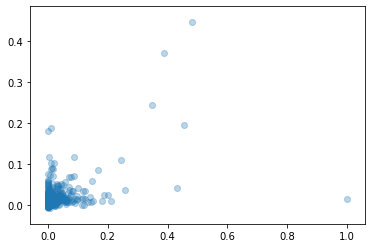

In [314]:
from matplotlib import pyplot as plt
plt.scatter(y_test, ml.predict(X_test), alpha=0.3)

In [315]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = ml.predict(X_test)
# The `squared=False` bit tells this function to return the ROOT mean squared error
mse = mean_squared_error(y_test, ml.predict(X_test))
mae = mean_absolute_error(y_test, ml.predict(X_test))
print("Root Mean Square Error:", np.sqrt(mse))
print("Mean Absolute Error:", mae)
print(f'CatBoost MAE score on the X_test is: {mean_absolute_error(y_test, y_pred)}')

Root Mean Square Error: 0.026126040349280778
Mean Absolute Error: 0.005953404270203989
CatBoost MAE score on the X_test is: 0.005953404270203989


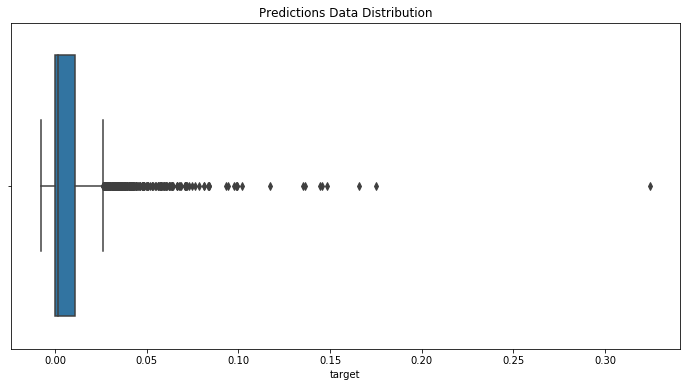

In [316]:
# Make prediction on the test set
test_df = test[main_cols]
predictions = ml.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.target = predictions

# Check the distribution of your predictions
plt.figure(figsize=(12, 6))
sns.boxplot(sub_file.target)
plt.title('Predictions Data Distribution');

In [317]:
# Preview the sub_file
sub_file.head()

,claim_id,target
0,ID_4RO0KZI9BBW2,0.02052
1,ID_GTE9ZUJ9GZ97,0.01172
2,ID_RUVIYRKWZ4RG,0.00360
3,ID_J81X8SWU6JYN,0.02635
4,ID_94NM3JJAWWOQ,0.00378


In [318]:
# Write to csv file to submit to Zindi
sub_file.to_csv("my submission.csv", index = False)